In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import tensorflow as tf 
import string
import re
import nltk
from nltk.corpus import stopwords  
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split  
import itertools 
from tensorflow.keras.callbacks import EarlyStopping 
import warnings 
warnings.filterwarnings('ignore') 

Importing data from Kaggle dataset collections  

In [5]:
data = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv') 
data['review'] = data['review'].str.lower()     
data.head(5) 

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [6]:
len(data)  

50000

In [7]:
data['sentiment'].value_counts()    # Balanced    

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
stopw =    stopwords.words('english')
stopw[:10]         

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Removing Stopwords, HTML tags, prediction 

In [9]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopw)]))
  return data

## removing HTML tags  
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
    
data_2 = remove_stopwords(data)
data_2['clean_review']= data_2['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_2['clean_review'] = data_2['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')

data_2.head(3)   

,review,sentiment,review without stopwords,clean_review
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...,wonderful little production the filming techn...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...


In [15]:
reviews = data_2['clean_review']    
reviews_list = []      
for i in range(len(reviews)):
    reviews_list.append(reviews[i])
 
sentiment = data_2['sentiment']    

len(reviews_list)  , len(sentiment)    
reviews_list[:3]  

['one reviewers mentioned watching 1 oz episode hooked  right  exactly happened me the first thing struck oz brutality unflinching scenes violence  set right word go  trust me  show faint hearted timid  show pulls punches regards drugs  sex violence  hardcore  classic use word it called oz nickname given oswald maximum security state penitentary  focuses mainly emerald city  experimental section prison cells glass fronts face inwards  privacy high agenda  em city home many  aryans  muslims  gangstas  latinos  christians  italians  irish more    so scuffles  death stares  dodgy dealings shady agreements never far away i would say main appeal show due fact goes shows dare  forget pretty pictures painted mainstream audiences  forget charm  forget romance   oz mess around  first episode ever saw struck nasty surreal  say ready it  watched more  developed taste oz  got accustomed high levels graphic violence  violence  injustice  crooked guards who ll sold nickel  inmates who ll kill order 

In [17]:
y = []
for i in sentiment:
    if i=="positive":
        y.append(1)
    else:
        y.append(0) 
y = np.array(y)     

# y = np.array(list(map(lambda x:1 if x=="positive" else 0  , sentiment))) 

sum(y)   ## Balanced dataset         

25000

In [18]:
## Train and test dataset 

X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 0 ) 


Keras tokenizer -> Dictionary maps each word to an unique index. more frequent words gets smaller index   

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

## Maps each word to an index - easy to have dictionary form of index and glove vector 
words_to_index = tokenizer.word_index  

dict(itertools.islice( words_to_index.items(), 10 ))        

{'s': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'i': 6,
 'it': 7,
 'good': 8,
 'the': 9,
 'even': 10}

In [37]:
len(list(set(words_to_index.keys()) ) )  

95363

In [20]:
len(words_to_index)    

95363

Importing pre-trained 100 dimensional Glove embeddings 

In [10]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec   

word_to_vec = read_glove_vector('../input/glove6b100dtxt/glove.6B.100d.txt')


In [11]:
dict(itertools.islice( word_to_vec.items(), 1 ))     ## word and corresponding 100d Glove embedding   

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [21]:
vocab_size  = len(words_to_index)      
embed_vector_size =100  
max_length = 150     ## Maximum sequence length -> 150 (using padding to ensure all reviews having this length)         
   
emb_matrix = np.zeros((vocab_size + 1 , embed_vector_size))        
 
for word, index in words_to_index.items():
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector    
        
emb_matrix.shape    , vocab_size           

((95364, 100), 95363)

3 layers of LSTM with 128 units each and RELU activation, dropout after each LSTM layer, Finally using one unit at output layer with sigmoid activation      


In [22]:
def imdb_rating(input_shape):
        
    X_indices = Input(input_shape)

    embedding_layer = Embedding(input_dim=vocab_size +1 , output_dim=embed_vector_size, input_length=max_length, weights = [emb_matrix], trainable=False)
    embeddings = embedding_layer(X_indices) 

    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model  

In [29]:
X_train[0]    

'that s redeeming quality movie otherwise insults viewer s intelligence losing track time  plot  reason produced plus  guy glasses ever got gig hollywood beyond me '

In [23]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=max_length, padding='post')    
X_train_indices[0] , X_train_indices.shape   

(array([  34,    1, 1665,  404,    2,  809,  436,    1, 1666, 2306, 1315,
          11,   42,  206,  944,  847,  117, 4358,   48,  103,  269,  595,
         135,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [32]:
## Splitting into train and validation 
X_train_2 , X_val ,Y_train_2 , Y_val = train_test_split(X_train_indices, Y_train , test_size=0.1, random_state = 0 ) 

X_train_2.shape , X_val.shape   

((36000, 150), (4000, 150))

In [33]:
model = imdb_rating((max_length,))
model.summary()        

2022-10-22 16:09:37.916447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 16:09:38.036414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 16:09:38.037324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 16:09:38.039034: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 100)          9536400   
_________________________________________________________________
lstm (LSTM)                  (None, 150, 128)          117248    
_________________________________________________________________
dropout (Dropout)            (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584

 Embedding layer maps each word to an 100 dimensional vector, so giving 150 word index (for a review) generates 150 such 100 dimensional ebeddings at embedding layer output. Then this 150*100 passes to 1st LSTM layer.  
 Input to LSTM is 150*100. each 100 dimensional vector will go through all units of LSTM, so 1 100d vector goes through 1st LSTM layer having 128 units, outputs into a 128 dimensional array, same for all other 149 vectors. to finally generate 150*128 output after 1st LSTM layer. again this 150*128 data sequentially passes through 2nd LSTM layer. and so on. This is when we choose return sequences = True, if not, output will be (1,128) i.e, output for only last word. Basically The inputs of each timestep will go through each unit in LSTM layer. Last i.e, 3rd LSTM layer generates single 128 dimensional vector which then mapped into a single output prediction unit.      

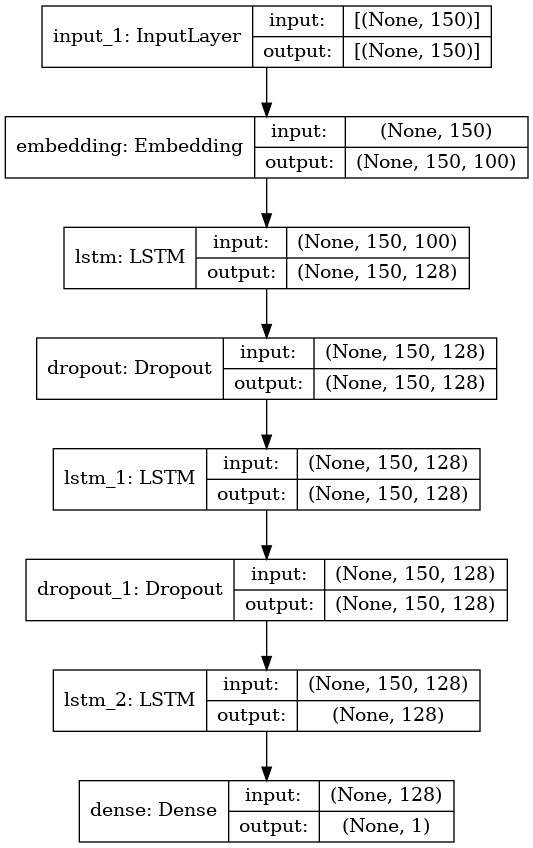

In [34]:
from keras.utils.vis_utils import plot_model  
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)      

In [48]:
X_test_indices = tokenizer.texts_to_sequences(X_test)  
X_test_indices = pad_sequences(X_test_indices, maxlen=max_length, padding='post') 
print(X_test_indices[0])    

[ 222 3963  425 1025 1241 1023 3122 3068  873  348  273  344  168  578
  284  199  888 1048  299 1890  525 3034  748  126    6   71 1890    5
 1766  179    4  103  464    9 2847 3122    1 4334 1688    1  442 1013
 2824    3  469   11   17  818   78  196   29 3963  865 1328  196    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [41]:
early_stopping_monitor = EarlyStopping(patience=10)   
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001) 

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_2 , Y_train_2  , batch_size=64, epochs=30 , validation_data=(X_val,Y_val),  callbacks=[early_stopping_monitor] )            


2022-10-22 16:20:03.775837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-22 16:20:08.453921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


563/563 [==============================] - 24s 31ms/step - loss: 0.5859 - accuracy: 0.6802 - val_loss: 0.4666 - val_accuracy: 0.7843
Epoch 2/30
563/563 [==============================] - 17s 29ms/step - loss: 0.4574 - accuracy: 0.7889 - val_loss: 0.4351 - val_accuracy: 0.8002
Epoch 3/30
563/563 [==============================] - 17s 30ms/step - loss: 0.4220 - accuracy: 0.8066 - val_loss: 0.4127 - val_accuracy: 0.8145
Epoch 4/30
563/563 [==============================] - 17s 29ms/step - loss: 0.4047 - accuracy: 0.8185 - val_loss: 0.3893 - val_accuracy: 0.8305
Epoch 5/30
563/563 [==============================] - 17s 30ms/step - loss: 0.3808 - accuracy: 0.8315 - val_loss: 0.3672 - val_accuracy: 0.8385
Epoch 6/30
563/563 [==============================] - 17s 30ms/step - loss: 0.3629 - accuracy: 0.8391 - val_loss: 0.3936 - val_accuracy: 0.8177
Epoch 7/30
563/563 [==============================] - 17s 29ms/step - loss: 0.3513 - accuracy: 0.8456 - val_loss: 0.3516 - val_accuracy: 0.8400
Epo

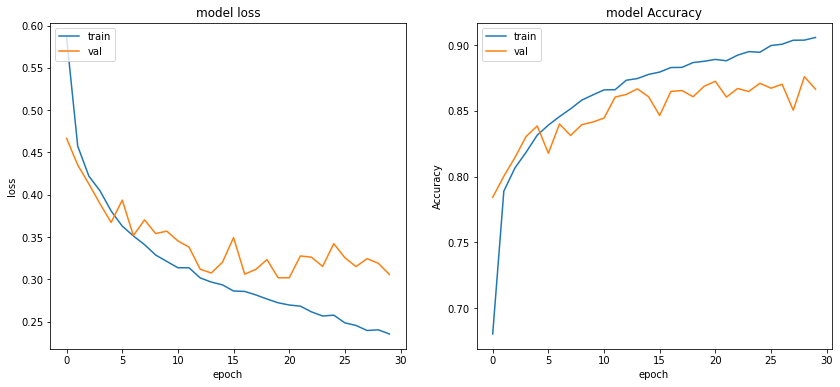

In [45]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])     
plt.title('model loss')
plt.ylabel('loss')   
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
   
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])     
plt.title('model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()           

In [46]:
test_predictions = (model.predict(X_test_indices) > 0.5).astype(int)
 
from sklearn.metrics import classification_report  

print(classification_report(Y_test, test_predictions))       

test_acc = model.evaluate(X_test_indices, Y_test)                

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      5035
           1       0.85      0.89      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

313/313 [==============================] - 3s 10ms/step - loss: 0.3134 - accuracy: 0.8654


In [47]:
acc = test_acc[1] * 100 
print("Testing Accuracy : {:.2f} %".format(acc) )       

Testing Accuracy : 86.54 %
